In [ ]:
#step 0 download the eurosat dataset
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d apollo2506/eurosat-dataset
!unzip eurosat-dataset.zip -d ./eurosat-dataset
!pip install torch torchvision matplotlib scikit-image

Streaming output truncated to the last 5000 lines.
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2012.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2013.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2014.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2015.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2016.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2017.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2018.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2019.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_202.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2020.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2021.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2022.tif  
  inflating: ./eurosat-dataset/EuroSATallBands/River/River_2023.tif  
  inflating: ./eurosat-dataset/EuroSATal

In [ ]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam

%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import tensorflow as tf
print("Number of GPUs available:", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Number of GPUs available: 1
/device:GPU:0


In [ ]:
def get_files_count(directory):
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def setup_to_transfer_learn(model, args):
    for l in model.layers[:-1]:
      l.trainable = False

    model.layers[-1].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    for l in model.layers[:not_trainable]:
      l.trainable = False

    for l in model.layers[not_trainable:]:
      l.trainable = True

    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def trainable_params(model, output_format = 'en_US'):
    def nr_to_string(number, separator = ','):
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret


In [ ]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1

    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    ax2.grid(True)

    plt.show()


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

class Args:
    def __init__(self, dataset_folder='/content/eurosat-dataset/EuroSAT', split_ratios=(0.7, 0.15, 0.15)):
        self.im_width, self.im_height = 224, 224
        self.lr = 0.0008
        self.batch_size = 32

        # Dataset folder
        self.dataset_folder = dataset_folder
        self.train_dir = os.path.join(dataset_folder, 'train')
        self.valid_dir = os.path.join(dataset_folder, 'valid')
        self.test_dir = os.path.join(dataset_folder, 'test')

        # Create splits
        self.split_ratios = split_ratios
        self._create_splits()

    def _create_splits(self):
        # Ensure directories exist
        for dir_path in [self.train_dir, self.valid_dir, self.test_dir]:
            os.makedirs(dir_path, exist_ok=True)

        # Iterate through class folders in dataset
        class_dirs = [d for d in os.listdir(self.dataset_folder) if os.path.isdir(os.path.join(self.dataset_folder, d))]
        for class_dir in class_dirs:
            class_path = os.path.join(self.dataset_folder, class_dir)
            if class_path in [self.train_dir, self.valid_dir, self.test_dir]:
                continue  # Skip already split directories

            # Get all files for the current class
            all_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            # Split files into train, valid, and test
            train_files, temp_files = train_test_split(all_files, test_size=1 - self.split_ratios[0], random_state=42)
            valid_files, test_files = train_test_split(temp_files, test_size=self.split_ratios[2] / sum(self.split_ratios[1:]), random_state=42)

            # Create class subdirectories
            for subset, subset_files in zip(['train', 'valid', 'test'], [train_files, valid_files, test_files]):
                subset_class_dir = os.path.join(self.dataset_folder, subset, class_dir)
                os.makedirs(subset_class_dir, exist_ok=True)
                for file in subset_files:
                    shutil.move(file, subset_class_dir)

# Instantiate Args
args = Args()


In [ ]:
import math

train_samples_count = get_files_count(args.train_dir)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()
nb_classes = len(classes)
valid_samples_count = get_files_count(args.valid_dir)
train_steps = math.ceil(train_samples_count / args.batch_size)
valid_steps = math.ceil(valid_samples_count / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(train_samples_count, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(valid_samples_count, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))

Train dataset contains 18890 samples (591 steps / epoch)
Valid dataset contains 4050 samples (127 steps / epoch)
Dataset contains 10 classes (['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']).


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 18890 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4060 images belonging to 10 classes.


In [ ]:
model = DenseNet121(include_top=False)
model = add_new_last_layer(model, nb_classes)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 6,964,106 (26.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
setup_to_transfer_learn(model, args)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data = validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 125s 163ms/step - accuracy: 0.7022 - loss: 0.9950 - val_accuracy: 0.9086 - val_loss: 0.2930
Epoch 2/2
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
len(model.layers)

429

In [ ]:
model.layers[411].get_config()['name']

'conv5_block15_0_bn'

In [ ]:
setup_to_finetune(model, args, not_trainable=418)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 1,
    validation_data = validation_generator,
    validation_steps = valid_steps,
)

591/591 ━━━━━━━━━━━━━━━━━━━━ 106s 139ms/step - accuracy: 0.9147 - loss: 0.2552 - val_accuracy: 0.9558 - val_loss: 0.1285


In [ ]:
model.layers[411].get_config()['name']

'conv5_block15_0_bn'

In [ ]:
setup_to_finetune(model, args, not_trainable=411)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 1,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

591/591 ━━━━━━━━━━━━━━━━━━━━ 110s 143ms/step - accuracy: 0.9548 - loss: 0.1289 - val_accuracy: 0.9659 - val_loss: 0.1004


In [ ]:
nb_test_samples = get_files_count(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9589 - loss: 0.1227


[0.11597783118486404, 0.9600694179534912]

In [ ]:
def findnth(string, substring, n):
    parts = string.split(substring, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(string) - len(parts[-1]) - len(substring)

def predict(image_path, classes):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.load_img(image_path)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_preprocessed = preprocess_input(input_arr)
    predictions = model.predict(img_preprocessed)

    ordered_predictions = [np.argsort(np.max(predictions, axis=0))[-i] for i in range(1, 6)]

    print("Image predictions:")
    for i in range(5):
        print("{}. {} - {:.4f}".format(i+1, classes[ordered_predictions[i]], np.round(predictions[0][ordered_predictions[i]], 4)))

    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image predictions:
1. River - 0.9944
2. SeaLake - 0.0035
3. HerbaceousVegetation - 0.0010
4. Forest - 0.0004
5. Highway - 0.0002


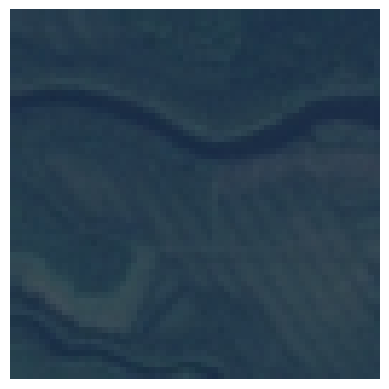

In [ ]:
image_path1 = '/content/eurosat-dataset/EuroSAT/test/River/River_1000.jpg'
predict(image_path1, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image predictions:
1. Highway - 0.9931
2. River - 0.0067
3. HerbaceousVegetation - 0.0002
4. Industrial - 0.0000
5. PermanentCrop - 0.0000


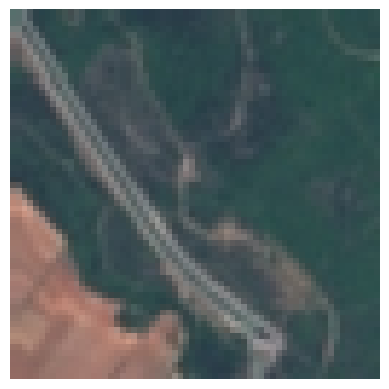

In [ ]:
image_path2 = '/content/eurosat-dataset/EuroSAT/test/Highway/Highway_1005.jpg'
predict(image_path2, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image predictions:
1. AnnualCrop - 0.9771
2. PermanentCrop - 0.0108
3. Highway - 0.0074
4. SeaLake - 0.0016
5. HerbaceousVegetation - 0.0009


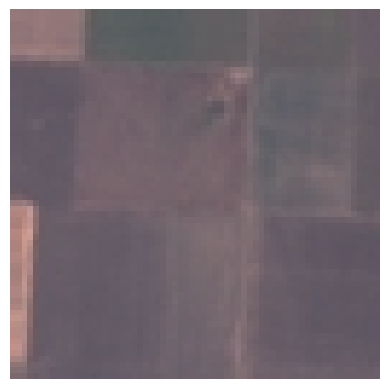

In [ ]:
image_path3 = '/content/eurosat-dataset/EuroSAT/test/AnnualCrop/AnnualCrop_1.jpg'
predict(image_path3, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image predictions:
1. Highway - 0.9979
2. Industrial - 0.0017
3. River - 0.0003
4. Residential - 0.0000
5. HerbaceousVegetation - 0.0000


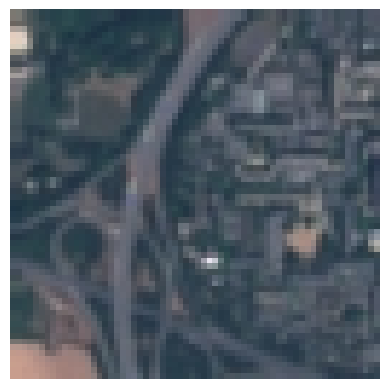

In [ ]:
image_path4 = '/content/eurosat-dataset/EuroSAT/test/Highway/Highway_1228.jpg'
predict(image_path4, classes)

In [ ]:
# Define y_scores from the model's predictions
y_scores = []  # To store model probabilities
y_true = []    # Already being populated in the existing code

for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)  # Fetch a batch of test data
    preds = model.predict(x_batch)  # Predict probabilities using the model
    y_scores.extend(preds[:, 1])  # Assuming binary classification, take the probability for the positive class
    y_true.extend(np.argmax(y_batch, axis=1))  # True labels (already in your code)

# Convert y_scores to a NumPy array
y_scores = np.array(y_scores)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

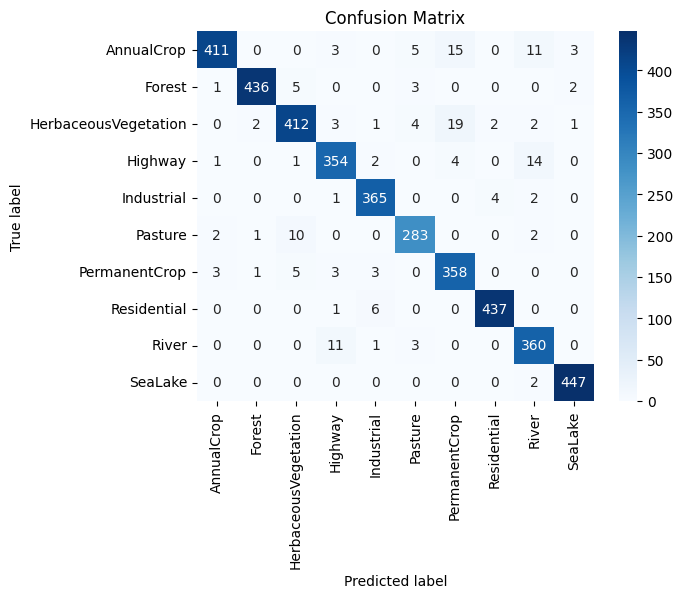

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.92      0.95       448
              Forest       0.99      0.98      0.98       447
HerbaceousVegetation       0.95      0.92      0.94       446
             Highway       0.94      0.94      0.94       376
          Industrial       0.97      0.98      0.97       372
             Pasture       0.95      0.95      0.95       298
       PermanentCrop       0.90      0.96      0.93       373
         Residential       0.99      0.98      0.99       444
               River       0.92      0.96      0.94       375
             SeaLake       0.99      1.00      0.99       449

            accuracy                           0.96      4028
           macro avg       0.96      0.96      0.96      4028
        weighted avg       0.96      0.96      0.96      4028

Precision: 0.9597
Recall: 0.9590
F1 Score: 0.9591


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plots the confusion matrix.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - classes: List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Get true labels and predictions
y_true = []
y_pred = []

# Assuming test_generator is defined and yields batches of test data
for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)  # Use next(test_generator)
    y_true.extend(np.argmax(y_batch, axis=1))  # Get true labels
    preds = model.predict(x_batch)  # Get predictions
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define your class names (this should match the order of your classes)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)

# Print classification report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━

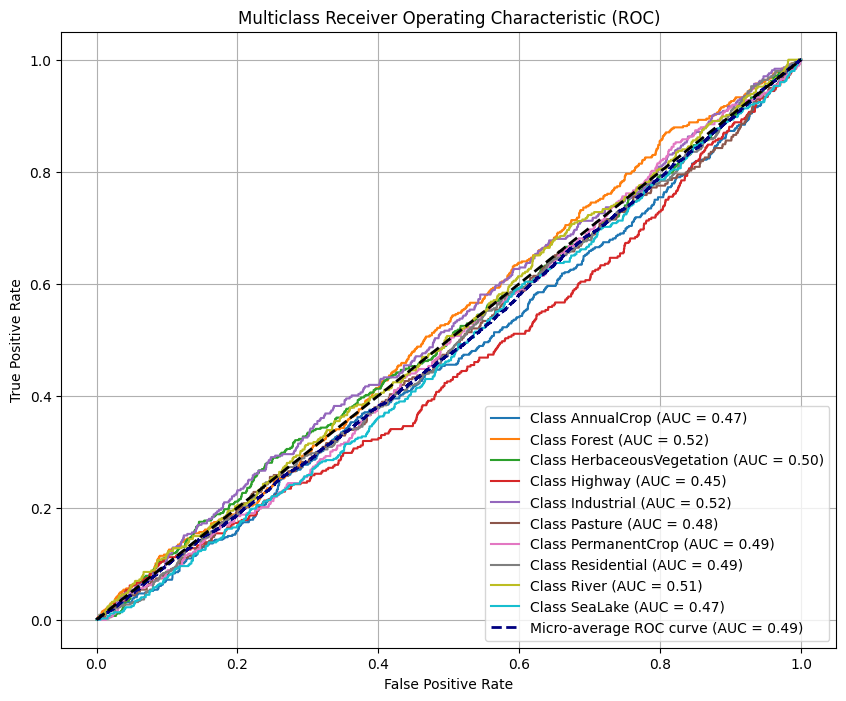

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Reinitialize y_scores to store probabilities for all classes
y_scores = []

# Loop through test batches and collect probabilities
for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)  # Get a batch from the test generator
    preds = model.predict(x_batch)  # Predict probabilities for all classes
    y_scores.extend(preds)  # Append the predictions for the batch

# Convert y_scores to a NumPy array
y_scores = np.array(y_scores)

# Ensure the number of samples in y_true and y_scores match
min_samples = min(len(y_true), y_scores.shape[0])

# Align y_true and y_scores by truncating to the smaller size
y_true_aligned = y_true[:min_samples]
y_scores_aligned = y_scores[:min_samples]

# Binarize the true labels (convert to one-hot encoding for multiclass ROC calculation)
y_true_binarized = label_binarize(y_true_aligned, classes=np.arange(len(classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores_aligned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_scores_aligned.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='navy', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
